[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SMase/lm_signate/blob/main/nb/mushroom/004_mush_shap.ipynb)

In [ ]:
# !nvidia-smi

# Config

In [1]:
# LightGBM Baseline
class Config:
    name_v1 = "lgb"
    model_params = dict(metric='auc',
                        objective="binary", 
                        )
    fit_params = dict(early_stopping_rounds=100, 
                      verbose_eval=100)
    

    n_fold = 5 
    seeds = [2021]
    target_col = "Y"
    submit = False
    debug = False

# SetUp

In [2]:
COMP = "signate"
COMP_NAME = "mushroom"
COMP_ID = 105
EXP = str(4).zfill(3)

In [3]:
import os
import shutil
from requests import get

from google.colab import drive, files
drive.mount('/content/drive')

!pip install --quiet signate
!pip install --quiet shap
!pip install --quiet optuna

os.makedirs("/root/.signate", exist_ok=True)  # API token 用のディレクトリを作成
token_path = f"/content/drive/MyDrive/{COMP}/signate.json"
shutil.copy(token_path, "/root/.signate")  # tokenをコピー

DRIVE = f"/content/drive/MyDrive/{COMP}/{COMP_NAME}" # Drive のパス
INPUT = os.path.join(DRIVE, "input")
OUTPUT = os.path.join(DRIVE, "output")
OUTPUT_EXP = os.path.join(OUTPUT, EXP)
OUTPUT_EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
OUTPUT_EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")
OUTPUT_EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
OUTPUT_EXP_FEATS = os.path.join(OUTPUT_EXP, "features")

SUBMISSION = os.path.join(DRIVE, "submission")

if not os.path.isdir(INPUT):  # 初回時にのみデータをINPUTフォルダにロード
    os.makedirs(INPUT, exist_ok=True)
    !signate download --competition-id=$COMP_ID --path=$INPUT

# 実験ごとのフォルダを作成
dirs = [INPUT, OUTPUT, OUTPUT_EXP, SUBMISSION, OUTPUT_EXP_MODEL, OUTPUT_EXP_PREDS, OUTPUT_EXP_FIG, OUTPUT_EXP_FEATS]
for d in dirs:
    os.makedirs(d, exist_ok=True)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [4]:
import logging
import datetime
import warnings

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.optimize import minimize, minimize_scalar

import shap
import optuna.integration.lightgbm as lgb
from lightgbm import LGBMModel

from sklearn.preprocessing import OneHotEncoder 
import os, gc
%cp -R $INPUT .

# Util

In [5]:
class Logger:
    """log を残す用のクラス"""
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

class Util:
    """pkl保存&load"""
    @classmethod
    def dump(cls, value, path):
        joblib.dump(value, path, compress=True)

    @classmethod
    def load(cls, path):
        return joblib.load(path)

class TunerCVCheckpointCallback(object):
    """Optuna の LightGBMTunerCV から学習済みモデルを取り出すためのコールバック"""

    def __init__(self):
        # オンメモリでモデルを記録しておく辞書
        self.cv_boosters = {}

    @staticmethod
    def params_to_hash(params):
        """パラメータを元に辞書のキーとなるハッシュを計算する"""
        params_hash = hash(frozenset(params.items()))
        return params_hash

    def get_trained_model(self, params):
        """パラメータをキーとして学習済みモデルを取り出す"""
        params_hash = self.params_to_hash(params)
        return self.cv_boosters[params_hash]

    def __call__(self, env):
        """LightGBM の各ラウンドで呼ばれるコールバック"""
        # 学習に使うパラメータをハッシュ値に変換する
        params_hash = self.params_to_hash(env.params)
        # 初登場のパラメータならモデルへの参照を保持する
        if params_hash not in self.cv_boosters:
            self.cv_boosters[params_hash] = env.model

In [6]:
warnings.filterwarnings("ignore")  # ignore warnings
logger = Logger(OUTPUT_EXP)  # set logger 

# Preprocessing

In [42]:
def get_baseline_features(train_test_df, features):
  # 目的変数変換
  target_mapping = {
      "p": 0,
      "e": 1
  }
  train_test_df.loc[:, Config.target_col] = train_test_df[Config.target_col].map(target_mapping)

  print(train_test_df)
  # 欠損値一括NONE補完
  for col in features:
    train_test_df.loc[:, col] = train_test_df[col].astype(str).fillna("NONE")

  print(train_test_df)

  return train_test_df


def preprocess(train, test):
    """前処理の実行関数"""
    train["is_train"] = True
    test["is_train"] = False
    train_test_df = pd.concat([train, test]).reset_index(drop=True)
    # 特徴量選択
    features = [f for f in train_test_df.columns if f not in ["id", Config.target_col, "is_train"]]

    funcs = [get_baseline_features,]

    output = []
    for func in funcs:
      filepath = os.path.join(OUTPUT_EXP_FEATS, f"{func.__name__}.pkl")
      if os.path.isfile(filepath):
        _df = Util.load(filepath)
      else:
        _df = func(train_test_df, features)  # 作った特徴量は保存
        Util.dump(_df, filepath)
      output.append(_df)
    output = pd.concat(output, axis=1)
    
    # OneHotエンコーダ
    ohe = OneHotEncoder()
    ohe.fit(output[features])
    # print([(f"{f}_{c}" for c in cs) for f, cs in zip(features, ohe.categories_)])
    # 学習、検証、テスト用データ作成
    train_X = ohe.transform(output[output["is_train"] == True][features])
    train_Y = output[output["is_train"] == True][Config.target_col]
    test_X = ohe.transform(output[output["is_train"] == False][features])

    columns = sum([[f"{f}_{c}" for c in cs] for f, cs in zip(features, ohe.categories_)], [])

    return train_X, train_Y, test_X, columns 

# Funcs

In [ ]:
class LGBM:
    """LGBMModelのラッパー"""
    def __init__(self):
        self.model = None

    def build(self):
        self.model = LGBMModel(**Config.model_params)
    
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y, eval_set=[(va_x, va_y)], **Config.fit_params)
    
    def predict(self, x):
        preds = self.model.predict(x)
        return preds

    def save(self, filepath):
        Util.dump(self.model, filepath)
    
    def load(self, filepath):
        self.model = Util.load(filepath)



def skf(train, n_splits, random_state):
    """層化KFoldのインデックスのリストを作成"""
    skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(skf.split(train, train[Config.target_col]))


def metrics(y_true, y_pred):
    """fbeta(beta=7)の閾値最適化評価関数"""
    bt = opt_fbeta_threshold(y_true, y_pred)
    print(f"bt:{bt}")
    score = fbeta_score(y_true, y_pred >= bt, beta=7)
    return score


def tree_importance(X, y, Model, cv):
    """importance を取得"""
    feature_importance_df = pd.DataFrame()
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.values[tr_idx], X.values[va_idx]
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]

        est = Model()
        est.build()

        est.fit(tr_x, tr_y, va_x, va_y) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.model.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    return fig, feature_importance_df


def visualize_confusion_matrix(
        y_true,
        pred_label,
        height=.6,
        labels=None):
    """混合行列をプロット"""
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    plt.show()
    return fig

## データ読み込み

In [43]:
# データセットマージ
train_df = pd.read_csv("./input/train.tsv", sep="\t")
test_df = pd.read_csv("./input/test.tsv", sep="\t")

if Config.debug:
    train_df = train_df.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)
    test_df = test_df.sample(1000, random_state=Config.seeds[0]).reset_index(drop=True)

# preprocess
print("# ============= # Preprocess # ============= #")
train_x, train_y, test_x, feature_columns = preprocess(train_df, test_df)
print(train_x.shape)

# LightGBM用のデータセットに変換
train_val = lgb.Dataset(train_x, train_y)

# 学習済みモデルへの参照を保持するためのコールバック
checkpoint_cb = TunerCVCheckpointCallback()
callbacks = [
    checkpoint_cb,
]
# クロスバリデーションによるハイパーパラメータの探索 3fold
tuner = lgb.LightGBMTunerCV(Config.model_params, train_val, early_stopping_rounds=100, 
                      verbose_eval=100, folds=StratifiedKFold(n_splits=3), callbacks=callbacks,)
# ハイパーパラメータ探索の実行
tuner.run()



# feature importace 
# print("# ============= # Importance # ============= #")
# fig, _df = tree_importance(X=train_x, y=train_y, Model=LGBM,
#                            cv=skf(n_splits=3,
#                                   random_state=Config.seeds[0]))
# fig.savefig(os.path.join(OUTPUT_EXP_FIG, "importance.png"), dpi=300)




[I 2021-12-05 10:30:28,158] A new study created in memory with name: no-name-b7225959-77a3-456d-8f15-3a2bca991ff7


# ============= # Preprocess # ============= #
(4062, 117)



feature_fraction, val_score: 1.000000:  14%|#4        | 1/7 [00:00<00:02,  2.26it/s][I 2021-12-05 10:30:28,622] Trial 0 finished with value: 1.0 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  14%|#4        | 1/7 [00:00<00:02,  2.26it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000:  29%|##8       | 2/7 [00:00<00:02,  2.15it/s][I 2021-12-05 10:30:29,100] Trial 1 finished with value: 1.0 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  29%|##8       | 2/7 [00:00<00:02,  2.15it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000:  43%|####2     | 3/7 [00:01<00:01,  2.14it/s][I 2021-12-05 10:30:29,574] Trial 2 finished with value: 1.0 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  43%|####2     | 3/7 [00:01<00:01,  2.14it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000:  57%|#####7    | 4/7 [00:01<00:01,  2.22it/s][I 2021-12-05 10:30:29,996] Trial 3 finished with value: 1.0 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  57%|#####7    | 4/7 [00:01<00:01,  2.22it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000:  71%|#######1  | 5/7 [00:02<00:00,  2.17it/s][I 2021-12-05 10:30:30,473] Trial 4 finished with value: 1.0 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  71%|#######1  | 5/7 [00:02<00:00,  2.17it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000:  86%|########5 | 6/7 [00:02<00:00,  2.06it/s][I 2021-12-05 10:30:31,005] Trial 5 finished with value: 1.0 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 1.0.

feature_fraction, val_score: 1.000000:  86%|########5 | 6/7 [00:02<00:00,  2.06it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction, val_score: 1.000000: 100%|##########| 7/7 [00:03<00:00,  2.05it/s]


[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:   5%|5         | 1/20 [00:00<00:14,  1.33it/s][I 2021-12-05 10:30:32,351] Trial 7 finished with value: 1.0 and parameters: {'num_leaves': 207}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:   5%|5         | 1/20 [00:00<00:14,  1.33it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  10%|#         | 2/20 [00:01<00:13,  1.32it/s][I 2021-12-05 10:30:33,119] Trial 8 finished with value: 1.0 and parameters: {'num_leaves': 230}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  10%|#         | 2/20 [00:01<00:13,  1.32it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  15%|#5        | 3/20 [00:02<00:11,  1.48it/s][I 2021-12-05 10:30:33,689] Trial 9 finished with value: 1.0 and parameters: {'num_leaves': 77}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  15%|#5        | 3/20 [00:02<00:11,  1.48it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  20%|##        | 4/20 [00:02<00:11,  1.44it/s][I 2021-12-05 10:30:34,409] Trial 10 finished with value: 1.0 and parameters: {'num_leaves': 120}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  20%|##        | 4/20 [00:02<00:11,  1.44it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  25%|##5       | 5/20 [00:03<00:10,  1.40it/s][I 2021-12-05 10:30:35,163] Trial 11 finished with value: 1.0 and parameters: {'num_leaves': 225}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  25%|##5       | 5/20 [00:03<00:10,  1.40it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  30%|###       | 6/20 [00:04<00:09,  1.47it/s][I 2021-12-05 10:30:35,782] Trial 12 finished with value: 1.0 and parameters: {'num_leaves': 87}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  30%|###       | 6/20 [00:04<00:09,  1.47it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  35%|###5      | 7/20 [00:04<00:09,  1.44it/s][I 2021-12-05 10:30:36,504] Trial 13 finished with value: 1.0 and parameters: {'num_leaves': 167}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  35%|###5      | 7/20 [00:04<00:09,  1.44it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  40%|####      | 8/20 [00:05<00:07,  1.57it/s][I 2021-12-05 10:30:37,018] Trial 14 finished with value: 1.0 and parameters: {'num_leaves': 48}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  40%|####      | 8/20 [00:05<00:07,  1.57it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  45%|####5     | 9/20 [00:06<00:07,  1.50it/s][I 2021-12-05 10:30:37,746] Trial 15 finished with value: 1.0 and parameters: {'num_leaves': 232}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  45%|####5     | 9/20 [00:06<00:07,  1.50it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  50%|#####     | 10/20 [00:06<00:06,  1.59it/s][I 2021-12-05 10:30:38,291] Trial 16 finished with value: 1.0 and parameters: {'num_leaves': 59}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  50%|#####     | 10/20 [00:06<00:06,  1.59it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  55%|#####5    | 11/20 [00:07<00:06,  1.49it/s][I 2021-12-05 10:30:39,052] Trial 17 finished with value: 1.0 and parameters: {'num_leaves': 155}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  55%|#####5    | 11/20 [00:07<00:06,  1.49it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  60%|######    | 12/20 [00:08<00:05,  1.45it/s][I 2021-12-05 10:30:39,788] Trial 18 finished with value: 1.0 and parameters: {'num_leaves': 252}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  60%|######    | 12/20 [00:08<00:05,  1.45it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  65%|######5   | 13/20 [00:08<00:04,  1.41it/s][I 2021-12-05 10:30:40,548] Trial 19 finished with value: 1.0 and parameters: {'num_leaves': 197}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  65%|######5   | 13/20 [00:08<00:04,  1.41it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  70%|#######   | 14/20 [00:09<00:03,  1.66it/s][I 2021-12-05 10:30:40,905] Trial 20 finished with value: 1.0 and parameters: {'num_leaves': 7}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  70%|#######   | 14/20 [00:09<00:03,  1.66it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  75%|#######5  | 15/20 [00:10<00:03,  1.54it/s][I 2021-12-05 10:30:41,656] Trial 21 finished with value: 1.0 and parameters: {'num_leaves': 193}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  75%|#######5  | 15/20 [00:10<00:03,  1.54it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  80%|########  | 16/20 [00:10<00:02,  1.47it/s][I 2021-12-05 10:30:42,419] Trial 22 finished with value: 1.0 and parameters: {'num_leaves': 203}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  80%|########  | 16/20 [00:10<00:02,  1.47it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  85%|########5 | 17/20 [00:11<00:02,  1.41it/s][I 2021-12-05 10:30:43,197] Trial 23 finished with value: 1.0 and parameters: {'num_leaves': 253}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  85%|########5 | 17/20 [00:11<00:02,  1.41it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  90%|######### | 18/20 [00:12<00:01,  1.39it/s][I 2021-12-05 10:30:43,934] Trial 24 finished with value: 1.0 and parameters: {'num_leaves': 175}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  90%|######### | 18/20 [00:12<00:01,  1.39it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000:  95%|#########5| 19/20 [00:13<00:00,  1.38it/s][I 2021-12-05 10:30:44,676] Trial 25 finished with value: 1.0 and parameters: {'num_leaves': 131}. Best is trial 7 with value: 1.0.

num_leaves, val_score: 1.000000:  95%|#########5| 19/20 [00:13<00:00,  1.38it/s]

[100]	cv_agg's auc: 1 + 0



num_leaves, val_score: 1.000000: 100%|##########| 20/20 [00:13<00:00,  1.44it/s]


[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  10%|#         | 1/10 [00:00<00:05,  1.67it/s][I 2021-12-05 10:30:46,096] Trial 27 finished with value: 1.0 and parameters: {'bagging_fraction': 0.7849010638900762, 'bagging_freq': 2}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  20%|##        | 2/10 [00:01<00:04,  1.87it/s][I 2021-12-05 10:30:46,586] Trial 28 finished with value: 1.0 and parameters: {'bagging_fraction': 0.9685999705969348, 'bagging_freq': 7}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  20%|##        | 2/10 [00:01<00:04,  1.87it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  30%|###       | 3/10 [00:01<00:03,  1.76it/s][I 2021-12-05 10:30:47,194] Trial 29 finished with value: 1.0 and parameters: {'bagging_fraction': 0.5843621835740501, 'bagging_freq': 5}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  40%|####      | 4/10 [00:02<00:03,  1.75it/s]

[100]	cv_agg's auc: 1 + 0


[I 2021-12-05 10:30:47,768] Trial 30 finished with value: 1.0 and parameters: {'bagging_fraction': 0.8494418913415611, 'bagging_freq': 2}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  50%|#####     | 5/10 [00:02<00:02,  1.82it/s][I 2021-12-05 10:30:48,281] Trial 31 finished with value: 1.0 and parameters: {'bagging_fraction': 0.9886266412085001, 'bagging_freq': 5}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  50%|#####     | 5/10 [00:02<00:02,  1.82it/s]

[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  60%|######    | 6/10 [00:03<00:02,  1.87it/s][I 2021-12-05 10:30:48,786] Trial 32 finished with value: 1.0 and parameters: {'bagging_fraction': 0.9365649651258117, 'bagging_freq': 7}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  60%|######    | 6/10 [00:03<00:02,  1.87it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  70%|#######   | 7/10 [00:03<00:01,  1.75it/s][I 2021-12-05 10:30:49,431] Trial 33 finished with value: 1.0 and parameters: {'bagging_fraction': 0.7811916872437331, 'bagging_freq': 3}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  70%|#######   | 7/10 [00:03<00:01,  1.75it/s]

[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  80%|########  | 8/10 [00:04<00:01,  1.77it/s][I 2021-12-05 10:30:49,977] Trial 34 finished with value: 1.0 and parameters: {'bagging_fraction': 0.5129167358872534, 'bagging_freq': 1}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  80%|########  | 8/10 [00:04<00:01,  1.77it/s]

[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000:  90%|######### | 9/10 [00:05<00:00,  1.73it/s][I 2021-12-05 10:30:50,588] Trial 35 finished with value: 1.0 and parameters: {'bagging_fraction': 0.6372964014464298, 'bagging_freq': 7}. Best is trial 27 with value: 1.0.

bagging, val_score: 1.000000:  90%|######### | 9/10 [00:05<00:00,  1.73it/s]

[100]	cv_agg's auc: 1 + 0



bagging, val_score: 1.000000: 100%|##########| 10/10 [00:05<00:00,  1.75it/s]

feature_fraction_stage2, val_score: 1.000000:  33%|###3      | 1/3 [00:00<00:00,  2.49it/s][I 2021-12-05 10:30:51,628] Trial 37 finished with value: 1.0 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 1.0.

feature_fraction_stage2, val_score: 1.000000:  33%|###3      | 1/3 [00:00<00:00,  2.49it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction_stage2, val_score: 1.000000:  67%|######6   | 2/3 [00:00<00:00,  2.53it/s][I 2021-12-05 10:30:52,014] Trial 38 finished with value: 1.0 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 1.0.

feature_fraction_stage2, val_score: 1.000000:  67%|######6   | 2/3 [00:00<00:00,  2.53it/s]

[100]	cv_agg's auc: 1 + 0



feature_fraction_stage2, val_score: 1.000000: 100%|##########| 3/3 [00:01<00:00,  2.49it/s]


[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:   5%|5         | 1/20 [00:00<00:08,  2.14it/s][I 2021-12-05 10:30:52,911] Trial 40 finished with value: 1.0 and parameters: {'lambda_l1': 0.00011063893686683654, 'lambda_l2': 0.19028403587044251}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:   5%|5         | 1/20 [00:00<00:08,  2.14it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  10%|#         | 2/20 [00:00<00:08,  2.10it/s][I 2021-12-05 10:30:53,395] Trial 41 finished with value: 1.0 and parameters: {'lambda_l1': 0.007915624472050584, 'lambda_l2': 0.06474639318783129}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  10%|#         | 2/20 [00:00<00:08,  2.10it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  15%|#5        | 3/20 [00:01<00:08,  2.08it/s][I 2021-12-05 10:30:53,875] Trial 42 finished with value: 1.0 and parameters: {'lambda_l1': 3.4946133743967365e-05, 'lambda_l2': 0.1315701557750787}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  15%|#5        | 3/20 [00:01<00:08,  2.08it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  20%|##        | 4/20 [00:01<00:07,  2.02it/s][I 2021-12-05 10:30:54,391] Trial 43 finished with value: 1.0 and parameters: {'lambda_l1': 1.6285181159291935e-08, 'lambda_l2': 0.002814905555874848}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  20%|##        | 4/20 [00:01<00:07,  2.02it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  25%|##5       | 5/20 [00:02<00:07,  2.04it/s][I 2021-12-05 10:30:54,888] Trial 44 finished with value: 1.0 and parameters: {'lambda_l1': 0.00031126248982365557, 'lambda_l2': 0.002447662308536985}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  25%|##5       | 5/20 [00:02<00:07,  2.04it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  30%|###       | 6/20 [00:02<00:06,  2.07it/s][I 2021-12-05 10:30:55,347] Trial 45 finished with value: 1.0 and parameters: {'lambda_l1': 0.15392336327200112, 'lambda_l2': 9.45208526264773e-06}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  30%|###       | 6/20 [00:02<00:06,  2.07it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  35%|###5      | 7/20 [00:03<00:06,  2.06it/s][I 2021-12-05 10:30:55,837] Trial 46 finished with value: 1.0 and parameters: {'lambda_l1': 1.7206606480864635e-05, 'lambda_l2': 1.0231516039794037e-05}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  35%|###5      | 7/20 [00:03<00:06,  2.06it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 0.99998 + 1.60534e-05



regularization_factors, val_score: 1.000000:  40%|####      | 8/20 [00:04<00:06,  1.77it/s][I 2021-12-05 10:30:56,569] Trial 47 finished with value: 1.0 and parameters: {'lambda_l1': 0.0001651889773623271, 'lambda_l2': 8.980755246201316}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  40%|####      | 8/20 [00:04<00:06,  1.77it/s]

[200]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  45%|####5     | 9/20 [00:04<00:05,  1.84it/s][I 2021-12-05 10:30:57,072] Trial 48 finished with value: 1.0 and parameters: {'lambda_l1': 0.0005609723484524287, 'lambda_l2': 2.617225513816711e-07}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  45%|####5     | 9/20 [00:04<00:05,  1.84it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  50%|#####     | 10/20 [00:05<00:05,  1.87it/s][I 2021-12-05 10:30:57,579] Trial 49 finished with value: 1.0 and parameters: {'lambda_l1': 6.84004981455725e-08, 'lambda_l2': 0.1149359429657205}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  50%|#####     | 10/20 [00:05<00:05,  1.87it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 0.999798 + 0.000254991
[200]	cv_agg's auc: 0.999843 + 0.000196766



regularization_factors, val_score: 1.000000:  55%|#####5    | 11/20 [00:05<00:05,  1.58it/s][I 2021-12-05 10:30:58,431] Trial 50 finished with value: 0.9998427099330862 and parameters: {'lambda_l1': 3.0096322945987164, 'lambda_l2': 4.65029092898836}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  60%|######    | 12/20 [00:06<00:04,  1.70it/s][I 2021-12-05 10:30:58,918] Trial 51 finished with value: 1.0 and parameters: {'lambda_l1': 0.017981550544023225, 'lambda_l2': 0.11254447969357925}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  60%|######    | 12/20 [00:06<00:04,  1.70it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  65%|######5   | 13/20 [00:06<00:03,  1.77it/s][I 2021-12-05 10:30:59,437] Trial 52 finished with value: 1.0 and parameters: {'lambda_l1': 0.011776967237368144, 'lambda_l2': 0.00843855768132265}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  65%|######5   | 13/20 [00:07<00:03,  1.77it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  70%|#######   | 14/20 [00:07<00:03,  1.84it/s][I 2021-12-05 10:30:59,925] Trial 53 finished with value: 1.0 and parameters: {'lambda_l1': 1.6411744386374224e-06, 'lambda_l2': 0.00011994560848764645}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  70%|#######   | 14/20 [00:07<00:03,  1.84it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  75%|#######5  | 15/20 [00:08<00:02,  1.82it/s][I 2021-12-05 10:31:00,493] Trial 54 finished with value: 1.0 and parameters: {'lambda_l1': 0.010845593128889563, 'lambda_l2': 0.9614183152207427}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  75%|#######5  | 15/20 [00:08<00:02,  1.82it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  80%|########  | 16/20 [00:08<00:02,  1.88it/s][I 2021-12-05 10:31:00,978] Trial 55 finished with value: 1.0 and parameters: {'lambda_l1': 1.0002499193660399e-06, 'lambda_l2': 0.02214037670108985}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  80%|########  | 16/20 [00:08<00:02,  1.88it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  85%|########5 | 17/20 [00:09<00:01,  1.87it/s][I 2021-12-05 10:31:01,518] Trial 56 finished with value: 1.0 and parameters: {'lambda_l1': 0.8010267756342763, 'lambda_l2': 0.0005203914757285668}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  85%|########5 | 17/20 [00:09<00:01,  1.87it/s]

[100]	cv_agg's auc: 1 + 0



regularization_factors, val_score: 1.000000:  85%|########5 | 17/20 [00:09<00:01,  1.87it/s]


[100]	cv_agg's auc: 1 + 0


regularization_factors, val_score: 1.000000:  90%|######### | 18/20 [00:09<00:01,  1.85it/s][I 2021-12-05 10:31:02,074] Trial 57 finished with value: 1.0 and parameters: {'lambda_l1': 0.0010711780867920127, 'lambda_l2': 1.4612853474256908}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  95%|#########5| 19/20 [00:10<00:00,  1.89it/s][I 2021-12-05 10:31:02,573] Trial 58 finished with value: 1.0 and parameters: {'lambda_l1': 7.206377085296357e-07, 'lambda_l2': 5.12277395952774e-08}. Best is trial 40 with value: 1.0.

regularization_factors, val_score: 1.000000:  95%|#########5| 19/20 [00:10<00:00,  1.89it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 0.999987 + 1.555e-05



regularization_factors, val_score: 1.000000: 100%|##########| 20/20 [00:10<00:00,  1.86it/s]


[200]	cv_agg's auc: 0.999988 + 1.59872e-05



min_data_in_leaf, val_score: 1.000000:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's auc: 1 + 0



min_data_in_leaf, val_score: 1.000000:  20%|##        | 1/5 [00:00<00:02,  1.55it/s][I 2021-12-05 10:31:03,840] Trial 60 finished with value: 1.0 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 1.0.

min_data_in_leaf, val_score: 1.000000:  40%|####      | 2/5 [00:01<00:01,  1.87it/s][I 2021-12-05 10:31:04,307] Trial 61 finished with value: 1.0 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 1.0.

min_data_in_leaf, val_score: 1.000000:  40%|####      | 2/5 [00:01<00:01,  1.87it/s]

[100]	cv_agg's auc: 1 + 0



min_data_in_leaf, val_score: 1.000000:  60%|######    | 3/5 [00:01<00:00,  2.12it/s][I 2021-12-05 10:31:04,699] Trial 62 finished with value: 1.0 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 1.0.

min_data_in_leaf, val_score: 1.000000:  60%|######    | 3/5 [00:01<00:00,  2.12it/s]

[100]	cv_agg's auc: 1 + 0
[100]	cv_agg's auc: 1 + 0



min_data_in_leaf, val_score: 1.000000:  80%|########  | 4/5 [00:02<00:00,  1.96it/s][I 2021-12-05 10:31:05,266] Trial 63 finished with value: 1.0 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 1.0.

min_data_in_leaf, val_score: 1.000000: 100%|##########| 5/5 [00:02<00:00,  2.02it/s]

[100]	cv_agg's auc: 1 + 0


In [41]:
len(sum([[f"{f}_{c}" for c in cs] for f, cs in zip(features, categorys)], []))

117

In [32]:
features

['cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [12]:
# サーチしたパラメータの表示
best_params = tuner.best_params

print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

# 最も良かったパラメータをキーにして学習済みモデルを取り出す
cv_booster = checkpoint_cb.get_trained_model(tuner.best_params)
cv_booster.boosters

  Params: 
    metric: auc
    objective: binary
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20


num_leaves, val_score: 1.000000:  65%|######5   | 13/20 [21:12<11:25, 97.87s/it]


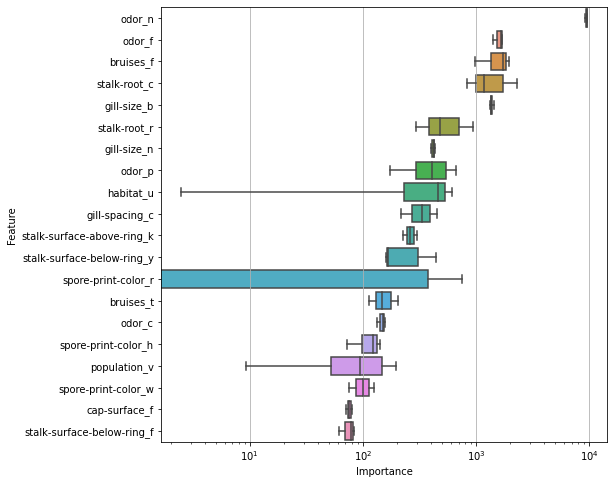

In [44]:
raw_importances = cv_booster.feature_importance(importance_type='gain')
feature_name = feature_columns
importance_df = pd.DataFrame(data=raw_importances,
                              columns=feature_name)
# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]
# 上位をプロットする
PLOT_TOP_N = 20
plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(8, 8))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
plt.show()

In [45]:
# Averaging でホールドアウト検証データを予測する
y_pred_proba_list = cv_booster.predict(test_x, num_iteration=cv_booster.best_iteration)
y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
y_pred = np.where(y_pred_proba_avg > 0.5, 1, 0)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [13]:
feature_importance_df = pd.DataFrame()
  for i, (tr_idx, va_idx) in enumerate(cv):
      tr_x, va_x = X.values[tr_idx], X.values[va_idx]
      tr_y, va_y = y.values[tr_idx], y.values[va_idx]

      est = Model()
      est.build()

      est.fit(tr_x, tr_y, va_x, va_y) 
      _df = pd.DataFrame()
      _df['feature_importance'] = est.model.feature_importances_
      _df['column'] = X.columns
      _df['fold'] = i + 1
      feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

  order = feature_importance_df.groupby('column') \
              .sum()[['feature_importance']] \
              .sort_values('feature_importance', ascending=False).index[:50]
  fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
  sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                palette='viridis')
  fig.tight_layout()
  ax.grid()
  ax.set_title('feature importance')
  fig.tight_layout()

['_Booster__attr',
 '_Booster__boost',
 '_Booster__get_eval_info',
 '_Booster__higher_better_inner_eval',
 '_Booster__init_predictor',
 '_Booster__inner_eval',
 '_Booster__inner_predict',
 '_Booster__inner_predict_buffer',
 '_Booster__is_predicted_cur_iter',
 '_Booster__name_inner_eval',
 '_Booster__need_reload_eval_info',
 '_Booster__num_class',
 '_Booster__num_dataset',
 '_Booster__num_inner_eval',
 '_Booster__set_objective_to_none',
 '_Booster__train_data_name',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_free_buffer',
 '_to_predictor',
 'add_valid',
 'attr',
 'best_iteration',
 'best_

In [14]:
cv_booster.boosters[0].feature_importance()


array([ 39,   0,  89,   9,   0,  69,  54,   0, 104,  57,  47,   0,  25,
        36,  85,  44,   0,   0, 145,  63, 132,  32,  41,  85, 125,  18,
         0,  98,  99,   1,   3,  15,  13, 121,  23, 112,  40,  38,  13,
        56,   0,   1,   0,   0,  18,   0,   0, 113,   1,  84,  31,  64,
        66,  58,   7,   9,   2,  82,   7,   0,  31,  26,  29,  84,   0,
         0,   4,   0,   0,   0,   1,  29,   0,   0,   0,   6,   0,  34,
         0,   8,  18,   0,   0,  13,   2,   1,   0,   0,  71,   9,  16,
         0,   0,   0,  20,   0,   9,  21,  41,   0,   0,   0,  96,   0,
         3,  46,  65,  61, 137,  18,  67, 107,  28,  46,  42,  53,   4])

In [ ]:
def run():
  





  train_df["is_train"] = True
  test_df["is_train"] = False
  train_test_df = pd.concat([train_df, test_df])

  # 目的変数変換
  target_mapping = {
      "p": 0,
      "e": 1
  }
  train_test_df.loc[:, "Y"] = train_test_df.Y.map(target_mapping)

  # 特徴量選択
  features = [f for f in train_df.columns if f not in ["id", "Y", "is_train"]]
  # 欠損値一括NONE補完
  for col in features:
    train_test_df.loc[:, col] = train_test_df[col].astype(str).fillna("NONE")

  # OneHotエンコーダ
  ohe = preprocessing.OneHotEncoder()
  ohe.fit(train_test_df[features])
  # 学習、検証、テスト用データ作成
  X = ohe.transform(train_test_df[train_test_df["is_train"] == True][features])
  y = train_test_df[train_test_df["is_train"] == True].Y
  X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)

  # 提出用データ作成
  X_train_submit = ohe.transform(train_test_df[train_test_df["is_train"] == False][features])

  # LightGBM用のデータセットに変換
  trainval = lgb.Dataset(X_trainval, y_trainval)

  # ハイパーパラメータサーチ&モデル構築
  params = {'objective': 'binary', 'metric': 'auc', 'random_seed':0, 'verbosity': -1, 'verbose_eval': 100, 'early_stopping_rounds': 100} 

  # 学習済みモデルへの参照を保持するためのコールバック
  checkpoint_cb = TunerCVCheckpointCallback()
  callbacks = [
      checkpoint_cb,
  ]
  # クロスバリデーションによるハイパーパラメータの探索 3fold
  tuner = lgb.LightGBMTunerCV(params, trainval, folds=StratifiedKFold(n_splits=3), callbacks=callbacks,)

  # ハイパーパラメータ探索の実行
  tuner.run()

  # サーチしたパラメータの表示
  best_params = tuner.best_params

  print("  Params: ")
  for key, value in best_params.items():
      print("    {}: {}".format(key, value))

  # 最も良かったパラメータをキーにして学習済みモデルを取り出す
  cv_booster = checkpoint_cb.get_trained_model(tuner.best_params)
  # Averaging でホールドアウト検証データを予測する
  y_pred_proba_list = cv_booster.predict(X_test, num_iteration=cv_booster.best_iteration)
  y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
  y_pred = np.where(y_pred_proba_avg > 0.5, 1, 0)
  
  



In [ ]:
!pip install heamy rgf-python

     |████████████████████████████████| 757 kB 4.2 MB/s 


In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df['X_train'], df['y_train'], test_size=0.2, random_state=0)

train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_dataset = lgbm.Dataset(data=X_valid, label=y_valid, free_raw_data=False)
final_train_dataset = lgbm.Dataset(data=df['X_train'], label=df['y_train'], free_raw_data=False)

lgbm_params = {
    'boosting': 'dart', 
    'application': 'binary',
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'num_leaves': 41,
    'metric': 'binary_logloss',
    'drop_rate': 0.15
}

evaluation_results = {}
clf = lgbm.train(train_set=train_dataset,
                 params=lgbm_params,
                 valid_sets=[train_dataset, test_dataset], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
                
clf_final = lgbm.train(train_set=final_train_dataset,
                      params=lgbm_params,
                      num_boost_round=500,
                      verbose_eval=0
                      )

y_pred = np.round(clf_final.predict(df['X_test'])).astype(int)

passengerId = pd.read_csv("./raw/test.tsv", sep="\t")['id']
dataframe = pd.DataFrame({'id': passengerId, 'survived': y_pred})

dataframe.to_csv('submission_single_lgbm_model.csv', index=False)

Early stopping is not available in dart mode


[20]	Train's binary_logloss: 0.49518	Test's binary_logloss: 0.579783
[40]	Train's binary_logloss: 0.435369	Test's binary_logloss: 0.55247
[60]	Train's binary_logloss: 0.421776	Test's binary_logloss: 0.540012
[80]	Train's binary_logloss: 0.404662	Test's binary_logloss: 0.534448
[100]	Train's binary_logloss: 0.397211	Test's binary_logloss: 0.529029
[120]	Train's binary_logloss: 0.389344	Test's binary_logloss: 0.526207
[140]	Train's binary_logloss: 0.378392	Test's binary_logloss: 0.521964
[160]	Train's binary_logloss: 0.380276	Test's binary_logloss: 0.519935
[180]	Train's binary_logloss: 0.35897	Test's binary_logloss: 0.520683
[200]	Train's binary_logloss: 0.343356	Test's binary_logloss: 0.51865
[220]	Train's binary_logloss: 0.334065	Test's binary_logloss: 0.5181
[240]	Train's binary_logloss: 0.323543	Test's binary_logloss: 0.522225
[260]	Train's binary_logloss: 0.31655	Test's binary_logloss: 0.525441
[280]	Train's binary_logloss: 0.310028	Test's binary_logloss: 0.5293
[300]	Train's binar

In [ ]:
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

from rgf.sklearn import RGFClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [ ]:
ds = Dataset(preprocessor=first_dataset, use_cache=False)
et_params = {'n_estimators': 100, 'max_features': 0.5, 'max_depth': 18, 'min_samples_leaf': 4, 'n_jobs': -1}
rf_params = {'n_estimators': 125, 'max_features': 0.2, 'max_depth': 25, 'min_samples_leaf': 4, 'n_jobs': -1}
rgf_params = {'algorithm': 'RGF_Sib', 'loss': 'Log'}

In [ ]:
from keras.layers import Dense
from keras.models import Sequential

def NuralNetClassifier(X_train, y_train, X_test, y_test=None):
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=0)
    y_pred = np.ravel(model.predict(X_test))
    
    return y_pred

In [ ]:
def LightGBMClassifier(X_train, y_train, X_test, y_test=None):
    lgbm_params = {
        'boosting': 'dart', 
        'application': 'binary',
        'learning_rate': 0.05,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'num_leaves': 41,
        'metric': 'binary_logloss',
        'drop_rate': 0.15
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
    test_dataset = lgbm.Dataset(data=X_valid, label=y_valid, free_raw_data=False)
    
    final_train_dataset = lgbm.Dataset(data=X_train, label=y_train, free_raw_data=False)
    
    evaluation_results = {}
    
    clf = lgbm.train(train_set=train_dataset,
                     params=lgbm_params,
                     valid_sets=[train_dataset, test_dataset], 
                     valid_names=['Train', 'Test'],
                     evals_result=evaluation_results,
                     num_boost_round=500,
                     early_stopping_rounds=100,
                     verbose_eval=0
                    )
    
    clf_final = lgbm.train(train_set=final_train_dataset,
                          params=lgbm_params,
                          num_boost_round=500,
                          verbose_eval=0
                          )

    y_pred = clf_final.predict(X_test)

    
    return y_pred

In [ ]:
pipeline = ModelsPipeline(
    Classifier(estimator=LightGBMClassifier, dataset=ds, use_cache=False),
    Classifier(estimator=NuralNetClassifier, dataset=ds, use_cache=False),
    Classifier(estimator=RGFClassifier, dataset=ds, use_cache=False, parameters=rgf_params),
    Classifier(estimator=ExtraTreesClassifier, dataset=ds, use_cache=False, parameters=et_params),
    Classifier(estimator=RandomForestClassifier, dataset=ds, use_cache=False, parameters=rf_params),
    Classifier(estimator=LogisticRegression, dataset=ds, use_cache=False),
    Classifier(estimator=KNeighborsClassifier, dataset=ds, use_cache=False)
)

In [ ]:
stack_ds = pipeline.stack(k=10, seed=0, add_diff=False, full_test=True)
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, use_cache=False)
y_pred = stacker.predict()
dataframe = pd.DataFrame({'id': pd.read_csv("./raw/test.tsv", sep="\t")['id'], 'survived': np.round(y_pred).astype(int)})
dataframe.to_csv('submission_heamy_single_stacking_model.csv', index=False)

Early stopping is not available in dart mode


In [ ]:
from sklearn.metrics import log_loss

pipeline2 = ModelsPipeline(
    Classifier(estimator=LightGBMClassifier, dataset=stack_ds, use_cache=False),
    Classifier(estimator=NuralNetClassifier, dataset=stack_ds, use_cache=False)
)

weights = pipeline2.find_weights(log_loss)
predictions = pipeline2.weight(weights).execute()

Early stopping is not available in dart mode


Best Score (log_loss): 0.47271785347006845
Best Weights: [0.49289792 0.50710208]


Early stopping is not available in dart mode


In [ ]:
dataframe = pd.DataFrame({'id': pd.read_csv("./raw/test.tsv", sep="\t")['id'], 'survived': np.round(y_pred).astype(int)})
dataframe.to_csv('submission_heamy_multiple_stacking_model.csv', index=False)

In [ ]:
from sklearn.ensemble import StackingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

lgbm_params = {
        'boosting': 'dart', 
        'application': 'binary',
        'learning_rate': 0.05,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.7,
        'num_leaves': 41,
        'metric': 'binary_logloss',
        'drop_rate': 0.15
}
keras_params = {'epochs': 10, 'batch_size': 10}

In [ ]:
def build_fn():
    clf = Sequential()
    clf.add(Dense(12, input_dim=9, activation='relu'))
    clf.add(Dense(6, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return clf

In [ ]:
estimators = [
    ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
    #('nn', KerasClassifier(build_fn=build_fn, **keras_params)),
    ('rgf', RGFClassifier(**rgf_params)),
    ('et', ExtraTreesClassifier(**et_params)),
    ('rf', RandomForestClassifier(**rf_params)),
    ('lr', LogisticRegression()),
    ('knn', KNeighborsClassifier())
]

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(df['X_train'], df['y_train'])
predictions = clf.predict(df['X_test'])
dataframe = pd.DataFrame({'id': pd.read_csv("./raw/test.tsv", sep="\t")['id'], 'survived': np.round(y_pred).astype(int)})
dataframe.to_csv('submission_sklearn_single_stacking_model.csv', index=False)

In [ ]:
final_estimator = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        ('lr', LogisticRegression())
    ],
    final_estimator=LogisticRegression()
)

In [ ]:
clf = StackingClassifier(
    estimators= [
        ('lgb', lgbm.LGBMClassifier(**lgbm_params)),
        #('nn', KerasClassifier(build_fn=build_fn, **keras_params)),
        ('rgf', RGFClassifier(**rgf_params)),
        ('et', ExtraTreesClassifier(**et_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier())
    ],
    final_estimator=final_estimator
)

In [ ]:
clf.fit(df['X_train'], df['y_train'])
predictions = clf.predict(df['X_test'])
dataframe = pd.DataFrame({'id': pd.read_csv("./raw/test.tsv", sep="\t")['id'], 'survived': np.round(y_pred).astype(int)})
dataframe.to_csv('submission_sklearn_multiple_stacking_model.csv', index=False)